In [142]:
import os
import numpy as np
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, Reshape
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

In [143]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))

Train Set Size = 60000 images
Test Set Size = 10000 images


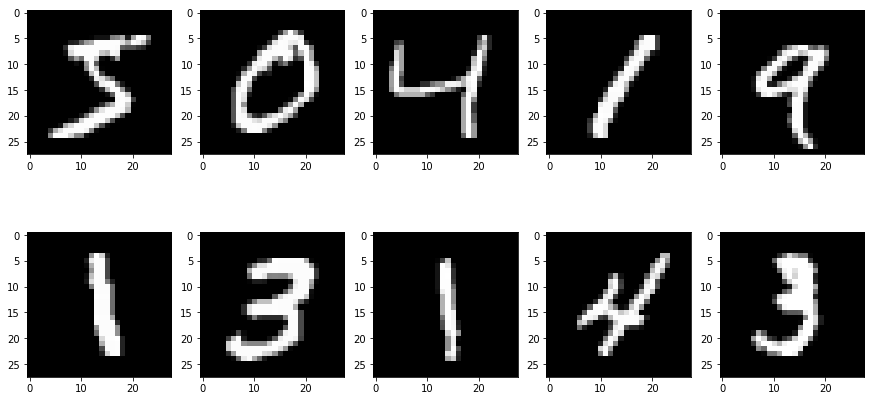

Labels : [5 0 4 1 9]
Labels : [1 3 1 4 3]


In [144]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

In [145]:
y_train_onehot = to_categorical(y_train, num_classes=None, dtype='float32')

In [146]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

def vgg16():
    model = Sequential()
    model.add(Reshape((28, 28, 1)))
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=((28, 28, 1)), activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))
    
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    #model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = vgg16()

In [147]:
nb_epoch = 50
batch_size = 128

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

def run_vgg16():
    
    history = LossHistory()
    model.fit(x_train, y_train_onehot, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(x_test, verbose=0)
    return predictions, history

def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [148]:
%%time
predictions, history = run_vgg16()
print(model.summary())

Train on 45000 samples, validate on 15000 samples
Epoch 1/50
45000/45000 [==============================] - 18s 399us/step - loss: 0.1134 - acc: 0.9625 - val_loss: 0.0314 - val_acc: 0.9920
Epoch 2/50
45000/45000 [==============================] - 15s 331us/step - loss: 0.0214 - acc: 0.9942 - val_loss: 0.0146 - val_acc: 0.9958
Epoch 3/50
45000/45000 [==============================] - 15s 332us/step - loss: 0.0132 - acc: 0.9965 - val_loss: 0.0143 - val_acc: 0.9967
Epoch 4/50
45000/45000 [==============================] - 15s 329us/step - loss: 0.0097 - acc: 0.9975 - val_loss: 0.0087 - val_acc: 0.9974
Epoch 5/50
45000/45000 [==============================] - 15s 333us/step - loss: 0.0074 - acc: 0.9981 - val_loss: 0.0099 - val_acc: 0.9979
Epoch 6/50
45000/45000 [==============================] - 15s 331us/step - loss: 0.0057 - acc: 0.9986 - val_loss: 0.0198 - val_acc: 0.9974
Epoch 7/50
45000/45000 [==============================] - 15s 331us/step - loss: 0.0054 - acc: 0.9987 - val_loss: 0.

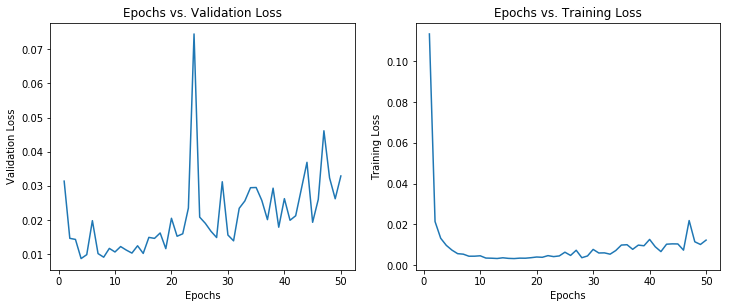

In [149]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,nb_epoch+1), history.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,nb_epoch+1), history.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

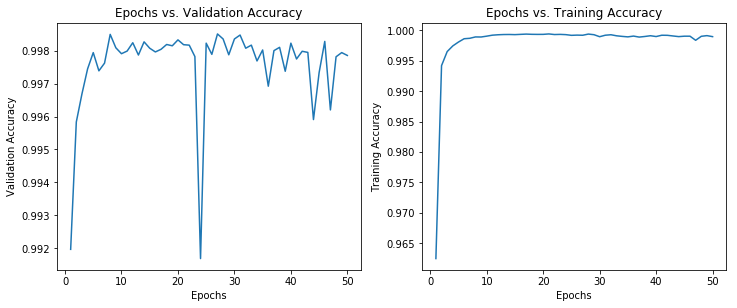

In [150]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,nb_epoch+1), history.val_acc)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,nb_epoch+1), history.acc)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

In [151]:
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 99.21 %


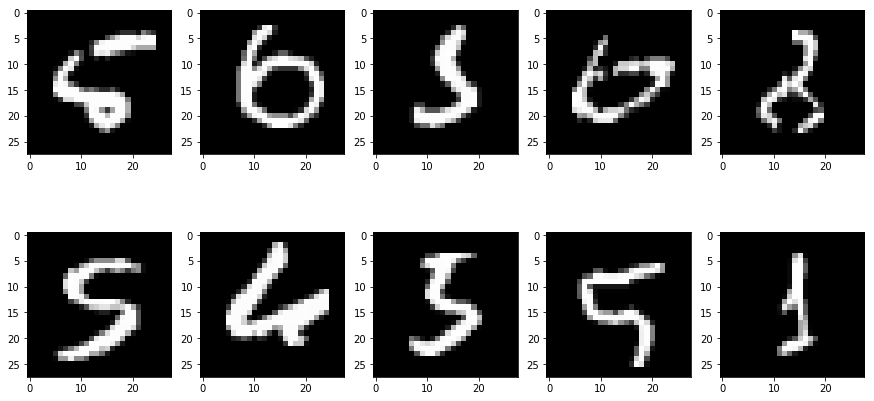

True:          [5 6 5 6 8]
classified as: [8 0 3 0 3]
True:          [5 6 5 5 1]
classified as: [9 4 3 9 3]


In [152]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))